In [58]:
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import polars as pl
import unittest
import xgboost as xgb

from sqlgbm import SQLGBM

titanic = pd.read_csv('assets/titanic.csv')
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = titanic[features]
y = titanic['survived']
X['sex'] = X['sex'].astype('category')
X['embarked'] = X['embarked'].astype('category')
cat_features = ['sex', 'embarked']
test_size = 0.2
n_samples = len(X)
n_test = int(test_size * n_samples)
np.random.seed(42)
test_indices = np.random.choice(n_samples, n_test, replace=False)
train_indices = np.array([i for i in range(n_samples) if i not in test_indices])
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]


xgb_clf = xgb.XGBClassifier(n_estimators=2, max_depth=1, enable_categorical=True, base_score=0.5)
xgb_clf.fit(X_train, y_train)

/var/folders/6d/f36lllj17b5bly7z1zr1q5n00000gn/T/ipykernel_25132/1086096619.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
/var/folders/6d/f36lllj17b5bly7z1zr1q5n00000gn/T/ipykernel_25132/1086096619.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
clf = lgb.LGBMClassifier(n_estimators=1, max_depth=1, verbose=-1, base_score=0.5)
clf.fit(X_train, y_train, categorical_feature=cat_features)
clf.booster_.trees_to_dataframe()
sqlgbm_lgb = SQLGBM(clf, X=X_train)
#sqlgbm_lgb.tree_df.to_clipboard()

In [60]:
xgb_clf.get_booster().trees_to_dataframe().to_clipboard()

In [61]:
sqlgbm_xgb = SQLGBM(xgb_clf, X=X_train)
sqlgbm_xgb.tree_df

,tree_index,Node,node_index,split_feature,threshold,left_child,right_child,Missing,value,Cover,Category,decision_type
0,0,0,0-0,sex,'female',0-2,0-1,0-1,195.252945,178.250000,[0],=
1,0,1,0-1,<NA>,NaN,NaN,NaN,NaN,-0.373248,116.750000,NaN,<
2,0,2,0-2,<NA>,NaN,NaN,NaN,NaN,0.283200,61.500000,NaN,<
3,1,0,1-0,sex,'female',1-2,1-1,1-1,100.495338,173.059540,[0],=
4,1,1,1-1,<NA>,NaN,NaN,NaN,NaN,-0.272699,112.776344,NaN,<
5,1,2,1-2,<NA>,NaN,NaN,NaN,NaN,0.204128,60.283192,NaN,<


In [62]:
dir(xgb_clf)
xgb_clf._Booster.trees_to_dataframe().to_clipboard()
booster = xgb_clf.get_booster()
booster.trees_to_dataframe().to_clipboard()

In [63]:
cat = clf.booster_.pandas_categorical

In [64]:
booster = xgb_clf.get_booster()
booster

In [65]:
sqlgbm_xgb = SQLGBM(xgb_clf, X=X_train)
table_name = 'self'
sql_query_xgb = sqlgbm_xgb.generate_query(table_name)
sql_query_proba_xgb = sqlgbm_xgb.generate_query(table_name, output_type='probability')
print(sql_query_xgb)

   tree_index  Node node_index split_feature threshold left_child right_child  \
0           0     0        0-0           sex  'female'        0-2         0-1   
1           0     1        0-1          <NA>       NaN        NaN         NaN   
2           0     2        0-2          <NA>       NaN        NaN         NaN   

  Missing       value   Cover Category decision_type  
0     0-1  195.252945  178.25      [0]             =  
1     NaN   -0.373248  116.75      NaN             <  
2     NaN    0.283200   61.50      NaN             <  
0-0
   tree_index  Node node_index split_feature threshold left_child right_child  \
3           1     0        1-0           sex  'female'        1-2         1-1   
4           1     1        1-1          <NA>       NaN        NaN         NaN   
5           1     2        1-2          <NA>       NaN        NaN         NaN   

  Missing       value       Cover Category decision_type  
3     1-1  100.495338  173.059540      [0]             =  
4     Na

<Axes: >

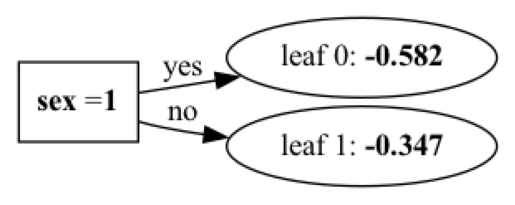

In [66]:
lgb.plot_tree(clf, tree_index=0)

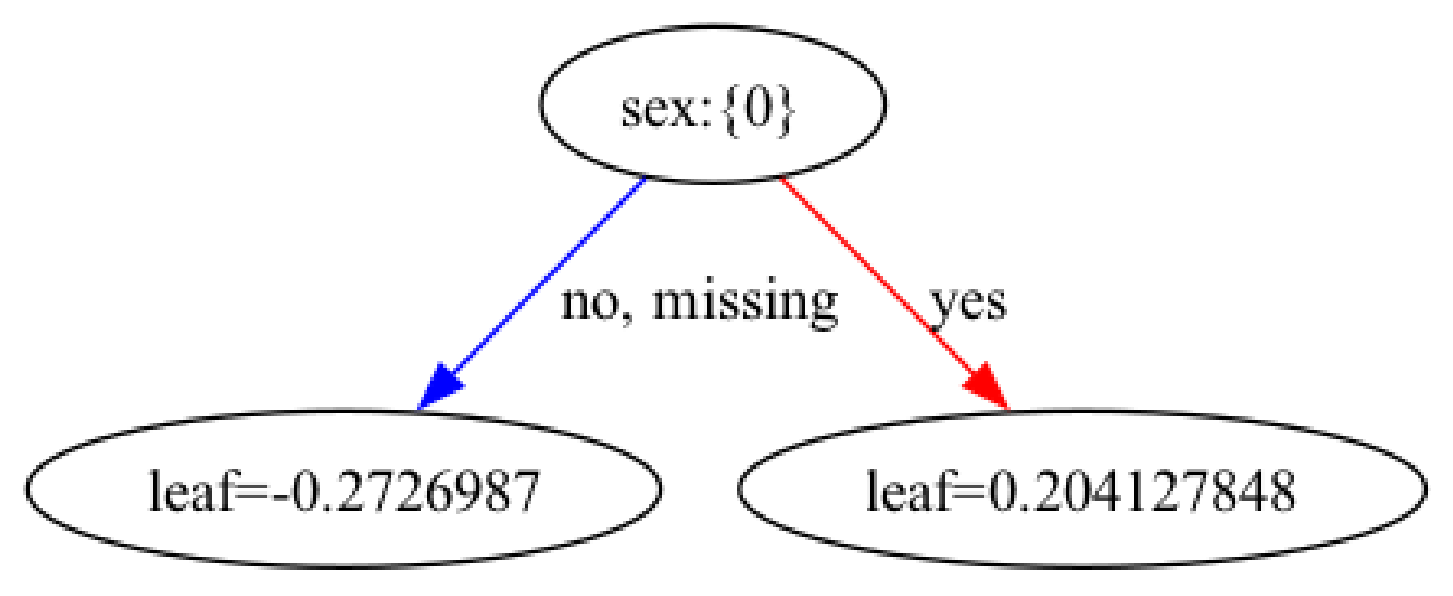

In [70]:
import matplotlib.pyplot as plt
xgb.plot_tree(xgb_clf, num_trees=1)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [75]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def fast_sigmoid(x):
  return x / (1 + abs(x))

for x in [-0.373248428, 0.283200026]:
  for y in [-0.2726987, 0.204127848]:
    p, not_p = sigmoid(x + y), 1 - sigmoid(x + y)
    print(x, y, min(p, not_p), max(p, not_p))


-0.373248428 -0.2726987 0.3439034230634457 0.6560965769365543
-0.373248428 0.204127848 0.45782034151783013 0.5421796584821699
0.283200026 -0.2726987 0.4973746926260596 0.5026253073739404
0.283200026 0.204127848 0.3805232539726364 0.6194767460273636


In [76]:
print(xgb_clf.base_score)

0.5


In [77]:
X_test.iloc[0]

pclass            3
sex            male
age            28.0
sibsp             1
parch             1
fare        15.2458
embarked          C
Name: 709, dtype: object

In [78]:
xgb_clf.predict_proba(X_test, )

array([[0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.38052326, 0.61947674],
       [0.38052326, 0.61947674],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.6560966 , 0.34390342],
       [0.38052326, 0.61947674],
       [0.

In [ ]:
import numpy as np
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def fast_sigmoid(x):
  x += 0.5
  return x / (1 + abs(x))

def inverse_sigmoid(x):
  return np.log(x / (1 - x))

fast_sigmoid(-0.244111702), fast_sigmoid(0.450961351)

In [ ]:
sql_que

In [ ]:
print(sql_query_xgb)

In [ ]:
y_pred_model = xgb_clf.predict(X_test)
df_pl = pl.from_pandas(X_test)
y_pred_sql = df_pl.sql(sql_query_xgb)['prediction'].to_list()
accuracy = sum(a == b for a, b in zip(y_pred_model, y_pred_sql)) / len(y_pred_model)

y_prob_model = xgb_clf.predict_proba(X_test)[:, 1]
y_prob_sql = df_pl.sql(sql_query_proba_xgb)['probability'].to_list()
mean_diff = np.mean(np.abs(y_prob_model - y_prob_sql))

In [ ]:
booster.dump_model("model.json")

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from scipy.special import expit as sigmoid, logit as inverse_sigmoid

# Load data
iris = datasets.load_iris()
X, y = iris.data, (iris.target == 1).astype(int)

# Fit a model
model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=10,
    use_label_encoder=False,
    objective='binary:logistic'
)
model.fit(X, y)
booster_ = model.get_booster()

# Extract indivudual predictions
individual_preds = []
for tree_ in booster_:
    individual_preds.append(
        tree_.predict(xgb.DMatrix(X))
    )
individual_preds = np.vstack(individual_preds)

# Aggregated individual predictions to final predictions
indivudual_logits = inverse_sigmoid(individual_preds)
final_logits = indivudual_logits.sum(axis=0)
final_preds = sigmoid(final_logits)

# Verify correctness
xgb_preds = booster_.predict(xgb.DMatrix(X))
np.testing.assert_almost_equal(final_preds, xgb_preds)